<a href="https://colab.research.google.com/github/pszwed-ai/lab-eksploracja-danych/blob/main/NLP_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przetwarzanie danych tekstowych z reddit.com
## Imię i nazwisko


Informacje o serwisie reddit można znaleźć w [Wikipedii](https://en.wikipedia.org/wiki/Reddit).


* Grupa tematyczna treści publikowanych w serwisie nazywana jest *subredditem*
* Wpis może mieć etykietę (tag), tzw. *flair*
* Z reddit można pobierać dane. W jednym żądaniu można pobrać maksymalnie 100 wpisów. W ciągu minuty można wykonać żądanie co najwyżej 60 razy

Podczas laboratorium  wykonamy dwa zadania:
* ZADANIE 1: pobierzemy dane z dwóch angielskojęzykowych subredditów *datascience* i *MachineLearning*, a następnie sprawdzimy, czy na podstawie treści można określić do której grupy należy wpis 
* ZADANIE 2: pobierzemy dane z kilku subredditów w języku polskim znalezionych [na tej stronie](https://www.reddit.com/r/Polska/wiki/subreddity/) i analogicznie sprawdzimy, czy udało się trafnie zgadnąć źródło tekstu


## 0.1 Ładowanie danych

Korzystamy z gotowego API. Co 100 wpisów robimy 1-sekundową przerwę. Podajemy ile pakietów po 100 postów chcemy pobrać (parametr ```length```).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import time
import sys

def pull_posts(subreddit, length):
    """Load length x 100 posts from a subreddit"""
    posts_list = []
    date = None
    while len(posts_list) < length:
        temp_url = 'https://api.pushshift.io/reddit/search/submission'
        temp_params = {'subreddit': subreddit, 'size': 100, 'before': date}
        temp_res = requests.get(temp_url,temp_params)
        if temp_res.status_code!=200:
          break
        print(f'Pulled {len(posts_list)} from {subreddit}')
        data = temp_res.json()
        posts = data['data']
        posts_list.append(posts)
        earliest_utc = sys.maxsize
        for p in posts:
          if p['created_utc']<earliest_utc:
            earliest_utc=p['created_utc']
        date = earliest_utc
        time.sleep(1.5)
    return posts_list

def flatten_list(post_groups):
  post_list = []
  for g in post_groups:
      for p in g:
          post_list.append(p)
  return post_list

# Próbnie pobieramy 2 pakiety po 100 wpisów

post_groups = pull_posts('datascience',2)
post_list = flatten_list(post_groups)
print(len(post_list))
print(post_list[0]['title']+' >> '+post_list[0]['selftext'])


200
Question: how to land a data science role with no degree? Can I land a job without prior experience or any degree but I've done courses on codecademy and google data analytics certificates? 

Are there other recognised certificates that employers would accept in absence of a degree?


Wyświetl załadowane dane. Teksty występują w kolumnach ```title``` i ```selftext```

In [ ]:
from google.colab import data_table
df = pd.DataFrame(post_list)
# df.head()
data_table.DataTable(df, include_index=False, num_rows_per_page=10,max_columns=81)


## 0.2 Przetwarzanie wstępne tekstu
Tekst powinien zostać poddany czyszczeniu i konwersji:
* usuwanie znaczników HTML i referencji (typu ```&lt;```)
* usuwanie znaków przestankowych
* zastępowanie specyficznych ciągów znaków symbolem ogólnym, np. zastępowanie liczb własnym znacznikiem ```#num#```, czasu ```#time#``` 

In [ ]:
from bs4 import BeautifulSoup
import re

def clean(text): 
    # znaczniki HTML
    # text = BeautifulSoup(text,features="lxml").get_text()
    text = BeautifulSoup(text, features="html.parser").get_text()

    # różne znaki, liczby
    # text = re.sub(r"C\+\+", "cpp", text) #języki
    # text = re.sub(r"C\#", "csharp", text) #języki
    # text = re.sub(r"[#\",!?;-<>/\\*\\&-]", " ", text) #znaki
    text = re.sub(r"\[[^\]]*\]\(http.+\)", " ", text) # linki markdown
    # text = re.sub(r"\d+:\d+(:\d+)?", "#time# ", text) #czas
    # text = re.sub(r"\d+\.?\d*", "#num# ", text) #liczby
    # text = re.sub('\[[^\]]*\]',' ',text) #
    text = re.sub(r"[\.\+\=()]", " ", text) #reszta znaków
    words = text.lower().split()
    return " ".join(words)

txt = """Architektura oprogramowania. 
         Framework ORM. Język programowania C++ (C#) &amp; &lt; &gt; <html> 
         \\ instrukcja if(x==-1) [removed] 
         Kilka liczb: 120k$ 500000$ 23 11.53 
         Time: 11:55, 12:23:00
         10MB pamieci około 2GB 
         Markdown **bold title**
         p [p] empty [] 
         link:  [https://github.com/louisfb01/start-machine-learning-in-2020](https://github.com/louisfb01/start-machine-learning-in-2020) """ 
clean(txt)

**TODO 11.0.2.1**
* w funkcji ```load_to_data_frame```:
  * sklej kolumny 'title' i 'selftext' (dodając spację) i umieść wynik w kolumnie 'text'
  * zastosuj do kazdego elementu kolumny 'text' funkcję clean()
  * zwróć obiekt DataFrame zawierający wyłącznie kolumny 'text', 'subreddit' i 'link_flair_text'. Możesz do tego użyć funkcji DataFrame loc()

In [ ]:
import datetime
def load_to_data_frame(subreddit,save=True):
  """Załaduj listę postów do pandas DataFrame. """
  post_groups = pull_posts(subreddit,10)
  post_list = flatten_list(post_groups)
  df = pd.DataFrame(post_list)
  if save:
    file_name = subreddit+f'_{datetime.datetime.today()}.csv'
    df.to_csv(file_name)

  # zabezpieczenie w przypadku pustych danych !
  df['title']=df['title'].replace(np.nan, '', regex=True)
  df['selftext']=df['selftext'].replace(np.nan, '', regex=True)  
 
  # sklej kolumny  
  ??? = ??? + " " + ???
  
  df['text']=df['text'].apply(????)
  return df.loc[:,[???,???,....]]


## 0.3 Wizualizacja w postaci interaktywnej tabeli

In [ ]:
df_ds = load_to_data_frame('datascience')
assert df_ds.shape[1]==3
from google.colab import data_table
data_table.DataTable(df_ds, include_index=False, num_rows_per_page=10)


,text,subreddit,link_flair_text
0,just got accepted to an ms data science progra...,datascience,Education
1,advice on joining a bootcamp hi i'm looking to...,datascience,Career
2,i need data to convince my professor cryptocur...,datascience,Education
3,data scientists without masters or phd how muc...,datascience,Career
4,data science cv,datascience,Discussion
...,...,...,...
995,identifying aliases among organization names w...,datascience,Discussion
996,has anyone ever made a html presentation inste...,datascience,Discussion
997,fun project tasting seattle through data hey j...,datascience,Projects
998,how do know if i'm made for data science i'm a...,datascience,Career


# ZADANIE 1: Data Science vs. Machine Learning
Czy *Data Science* i *Machine Learning* czymś różnią się? Czy na podstawie treści postów można je odróżnić? 

Pobierzemy posty z grup datasience i MachineLearning i umieścimy w jednej tabeli DataFrame

In [ ]:
def concat(subredits):
  df_list = []
  for s in subredits:
    df = load_to_data_frame(s)
    print(f'{s}:{len(df)}')
    time.sleep(1)
    df_list.append(df)
  return pd.concat(df_list,ignore_index=True)
  # return df_list

df = concat(['datascience','MachineLearning'])



Tabela powinna zawierać około 2200 wierszy i 3 kolumny. 




In [ ]:
data_table.DataTable(df, include_index=False, num_rows_per_page=10,max_columns=80)


,text,subreddit,link_flair_text
0,"i enjoy math and programming, but i'm not inte...",datascience,Career
1,"cnn with self-attention hi, i am just in the e...",datascience,Education
2,business fact [removed],datascience,Education
3,free premium content materials [removed],datascience,Education
4,generating vector tiles with postgis and pytho...,datascience,Education
...,...,...,...
1494,seeking a versatile question-answering tool fo...,MachineLearning,None
1495,[p] insights miner to auto-create analytics da...,MachineLearning,Project
1496,seeking a versatile question-answering tool fo...,MachineLearning,None
1497,seeking a versatile question-answering tool fo...,MachineLearning,None


In [ ]:
assert df.subreddit[999]=='datascience'
assert df.subreddit[1100]=='MachineLearning'


Czy posty zawierają słowo 'python'?

**TODO 11.1.1.1**
* znajdź indeksy wierszy zawierających słowo 'python'. Użyj metody [str.find()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.find.html)
* utwórz DataFrame zawierającą tylko te wiersze i wyświetl

Wydaje się, że słowo występuje w obu grupach postów

In [ ]:
indexes = ????
df_python=df[indexes ???? 0]
data_table.DataTable(df_python, include_index=True, num_rows_per_page=10)

,text,subreddit,link_flair_text
0,what is a data product consultant hello i am u...,datascience,Job Search
10,what's a good first step data management softw...,datascience,Discussion
13,collaction of paid python courses for free fro...,datascience,Education
23,difficulty finding job even after masters prog...,datascience,Job Search
25,plotly app to sharepoint hi i'm a self taught ...,datascience,Education
...,...,...,...
1801,onepanel open source extensible deep learning ...,MachineLearning,NaN
1908,a recent history of my pointless stare down wi...,MachineLearning,Discussion
1914,how are teslas so fast 🤯 does the neural netwo...,MachineLearning,Research
1921,time series analysis real world projects in py...,MachineLearning,NaN


## 1.1. Ekstrakcja etykiet

**TODO 11.1.1.2**
* Za pomocą LabelEncoder zakoduj jako liczby etykiety z kolumnt ```subreddit```




In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y=le.?????
le.classes_

array(['MachineLearning', 'datascience'], dtype=object)

## 1.2 Ekstrakcja cech
Wypróbujemy CountVectorizer i TfidfVectorizer
* Oba mogą wyodrębniać n-gramy (ciągi n symboli)
* Symbolami mogą być słowa lub znaki
* Oba pozwalają na ograniczenie liczby terminów

**TODO  11.1.2.1**
* Co to jest TF-IDF?
* Czym TfidfVectorizer różni się od CountVectorizer
* Obejrzyj wyjście i skasuj! 

In [ ]:
#max 2 słowa
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2),max_features=1000)
X = vectorizer.fit_transform(df['text'])
vectorizer.vocabulary_
# vectorizer.stop_words_

In [ ]:
# znaki (max 8)
vectorizer = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,8),max_features=1000)
X = vectorizer.fit_transform(df['text'])
vectorizer.vocabulary_



Stopwords to terminy odrzucone (występujące zbyt czesto lub zbyt rzadko)

In [ ]:
# tylko zliczanie słów 
vectorizer = CountVectorizer(analyzer='word',ngram_range=(1,2),max_features=1000)
X = vectorizer.fit_transform(df['text'])
vectorizer.stop_words_

**TODO 11.1.2.2** 
* za pomocą ```CountVectorizer``` wyznacz 30 najczęściej występujacych słów. 
* Z reguły najczęściej występujące słowa nie przenoszą żadnaego znaczenia [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

In [ ]:
vectorizer = CountVectorizer(????)
vectorizer.fit(df.text)
stopwords = vectorizer.vocabulary_
stopwords


{'and': 0,
 'are': 1,
 'as': 2,
 'be': 3,
 'but': 4,
 'can': 5,
 'data': 6,
 'for': 7,
 'from': 8,
 'have': 9,
 'how': 10,
 'if': 11,
 'in': 12,
 'is': 13,
 'it': 14,
 'learning': 15,
 'link': 16,
 'my': 17,
 'num': 18,
 'of': 19,
 'on': 20,
 'or': 21,
 'science': 22,
 'that': 23,
 'the': 24,
 'this': 25,
 'to': 26,
 'what': 27,
 'with': 28,
 'you': 29}

## 1.3 Klasyfikacja
Utworzony zostanie ciąg przetwarzania (ang. pipeline) składający się z dwóch kroków:
* ekstrakcji cech z tekstów za pomocą TfidfVectorizer
* klasyfikacji z użyciem MultinomialNB

**TODO 11.1.3.1**
* Przetestuj co najmniej 3 konfiguracje Vectorizera i wybierz tę, która wydaje się zwracać lepsze wyniki. Na przykład oblicz średnią F1 z 10 iteracji. Napisz, którą wybrałeś
* Uwaga wyniki mogą się zmieniac, ponieważ zależą od pobranych danych. 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2),stop_words=stopwords,max_features=1000)
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2),max_features=1000)
cls = MultinomialNB()

pipeline = make_pipeline(vectorizer, cls)
from sklearn.model_selection import train_test_split
import sklearn
f1s=[]
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size = 0.1, random_state = i)
  pipeline.fit(X_train,y_train)
  y_pred = pipeline.predict(X_test)
  print(f'Accuracy:{sklearn.metrics.accuracy_score(y_test,y_pred)} F1: {sklearn.metrics.f1_score(y_test,y_pred,average="macro")}')
  f1s.append(sklearn.metrics.f1_score(y_test,y_pred,average="macro"))
print(np.array(f1s).mean())



Accuracy:0.825 F1: 0.8248905565978737
Accuracy:0.825 F1: 0.824785362068534
Accuracy:0.785 F1: 0.7843476516462298
Accuracy:0.78 F1: 0.77997799779978
Accuracy:0.83 F1: 0.8299319727891157
Accuracy:0.805 F1: 0.804995124878122
Accuracy:0.81 F1: 0.8099239695878351
Accuracy:0.785 F1: 0.7849946248656215
Accuracy:0.79 F1: 0.7899159663865546
Accuracy:0.82 F1: 0.8200000000000001
0.8053763226619666


## 1.4 Walidacja krzyżowa

**TODO 11.1.4.1**
* Oblicz i wypisz średnie wartości metryk

In [ ]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
# scoring = scoring=['accuracy','f1_macro']
cv_results = cross_validate(pipeline, df['text'], y, cv=10,scoring=scoring)

???
???
???
???

print(f'acc={acc} prec={prec} recall={recall} f1={f1}')


# ZADANIE 2 - Z której grupy pochodzi post w języku polskim

Celem drugiego zadania jest analogiczna próba klasyfikajci tesktów pochodzących z polskich subredditów. 

Wykonamy analogiczne kroki jak w Zadaniu 1.



## 2.1 Ładujemy i wyświetlamy dane

**Wybierz co najmniej 4 źródła, niekoniecznie takie, jak w podanym przykładzie.** 

In [ ]:
df = concat(['FashionRepsPolska','RPGPolska','PolskaPolityka','Krakow'])
df.to_csv("various_polish.csv", encoding="utf-8") 

Pulled 0 from FashionRepsPolska
Pulled 1 from FashionRepsPolska
Pulled 2 from FashionRepsPolska
Pulled 3 from FashionRepsPolska


<ipython-input-4-209cfc2be6c8>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()


FashionRepsPolska:400
Pulled 0 from RPGPolska
Pulled 1 from RPGPolska
Pulled 2 from RPGPolska


<ipython-input-4-209cfc2be6c8>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()


RPGPolska:300
Pulled 0 from PolskaPolityka
Pulled 1 from PolskaPolityka
Pulled 2 from PolskaPolityka
Pulled 3 from PolskaPolityka
Pulled 4 from PolskaPolityka
Pulled 5 from PolskaPolityka
Pulled 6 from PolskaPolityka
Pulled 7 from PolskaPolityka
Pulled 8 from PolskaPolityka
Pulled 9 from PolskaPolityka
Pulled 10 from PolskaPolityka


<ipython-input-4-209cfc2be6c8>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()


PolskaPolityka:1096
Pulled 0 from Krakow
Pulled 1 from Krakow
Pulled 2 from Krakow
Pulled 3 from Krakow
Pulled 4 from Krakow
Pulled 5 from Krakow
Pulled 6 from Krakow
Pulled 7 from Krakow
Pulled 8 from Krakow
Pulled 9 from Krakow
Pulled 10 from Krakow


<ipython-input-4-209cfc2be6c8>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, features="html.parser").get_text()


Krakow:1100


... gdybyśmy chcieli wczytać dane bez ich powtórnego ładowania

In [ ]:
# import pandas as pd
# df = pd.read_csv("various_polish.csv")

Tę wersję można też pobrać z Chmury AGH

In [ ]:
# !wget https://dysk.agh.edu.pl/s/qXz2B54Ctkm7Zgp/download/various_polish.csv.zop -O various_polish_csv.zip

--2023-05-17 18:33:41--  https://dysk.agh.edu.pl/s/qXz2B54Ctkm7Zgp/download/various_polish.csv.zop
Resolving dysk.agh.edu.pl (dysk.agh.edu.pl)... 149.156.96.4, 2001:6d8:10:1060::6004
Connecting to dysk.agh.edu.pl (dysk.agh.edu.pl)|149.156.96.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214084 (209K) [application/zip]
Saving to: ‘various_polish_csv.zip’

various_polish_csv. 100%[===================>] 209.07K   419KB/s    in 0.5s    

2023-05-17 18:33:42 (419 KB/s) - ‘various_polish_csv.zip’ saved [214084/214084]



In [ ]:
df.head(10)

,text,subreddit,link_flair_text
0,qc,FashionRepsPolska,None
1,czy ktoś korzystał z programu zwrotów za detai...,FashionRepsPolska,None
2,qc,FashionRepsPolska,None
3,"pytanie siema, 2 koszulki łącznie 800g myslici...",FashionRepsPolska,None
4,za ile paka moze byc i czy nic podejrzanego si...,FashionRepsPolska,None
5,"czym wyslac problem z cssbuy siema, ogolnie to...",FashionRepsPolska,None
6,siema podpowiedziałby mi ktoś na pv odnośnie p...,FashionRepsPolska,None
7,"qc na te yeezuski, co myślicie?",FashionRepsPolska,LCQC
8,rl czy gl? z góry thank u za pomoc batch niezn...,FashionRepsPolska,LCQC
9,paka dhl 6kg [removed],FashionRepsPolska,None


## 2.2 Usuwamy teksty w języku innym niż polski
Część tekstów jest w języku angielskim Nie chcemy ich używać podczas klasyfikacji. 

Potrzebne będzie narzędzie do rozpoznawania języka. W tym celu wykorzystamy bibliotekę  [spaCy](https://spacy.io/)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy_language_detection


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-17 17:55:32.564047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 17:55:33.802403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.0 MB/s eta 0:00:00
  Pr

Jeżeli pojawi się informacja o konieczności ponownego uruchomienia środowiska wykonawczego - możesz wczytać zapisany wcześniej plik.

In [ ]:
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42


nlp_model = spacy.load("en_core_web_sm")
# Language.factory("language_detector", func=get_lang_detector)
# nlp_model.add_pipe('language_detector', last=True)


Zarejestruj rozszerzenie - detektor języka (tylko raz podczas sesji).

Obiekt ```nlp_model``` jest singletonem zawierającym min. model języka oraz standardowy ciąg przetwarzania tekstu składający się z:
* tokenizera (czyli odpowiednik klasy Vectorizer)
* taggera (przypisywanie znaczników części mowy do symboli)
* parsera (buduje graf syntaktycznych zależności)
* NER - rozpoznawanie nazwanych terminów (takich, jak Bill Gates lub USA) 

Language detection to dodatkowy etap, jego powtórne zarejestrowanie powodowałoby błędy.

In [ ]:
# Zarejestruj rozszerzenie - detektor języka (tylko raz podczas sesji)

Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

Zobacz, jak działa rozpoznawanie języka...

In [ ]:
# Document level language detection
job_title = "Senior NLP Research Engineer"
doc = nlp_model(job_title)
language = doc._.language
print(language)



{'language': 'en', 'score': 0.9999944616311092}


In [ ]:
# Sentence level language detection
text = """This is English text. 
        Er lebt mit seinen Eltern und seiner Schwester in Berlin. 
        Yo me divierto todos los días en el parque. 
        Je m'appelle Angélica Summer, j'ai 12 ans et je suis canadienne. 
        Cześć, jestem Jan Kowalski z Warszawy.
        Ahoj, tady Pavel.
        Dobrý deň, tu je Pavel."""
doc = nlp_model(text)
for i, sent in enumerate(doc.sents):
    print(sent, sent._.language)

This is English text. 
         {'language': 'en', 'score': 0.9999987929307772}
Er lebt mit seinen Eltern und seiner Schwester in Berlin. 
         {'language': 'de', 'score': 0.999996045846908}
Yo me divierto todos los días en el parque. 
         {'language': 'es', 'score': 0.9999960751128255}
Je m'appelle Angélica Summer, j'ai 12 ans et je suis canadienne. 
         {'language': 'fr', 'score': 0.9999960488878064}
Cześć, jestem Jan Kowalski z Warszawy.
         {'language': 'pl', 'score': 0.9999984483477709}
Ahoj, tady Pavel.
         {'language': 'cs', 'score': 0.9999944828639359}
Dobrý deň, tu je Pavel. {'language': 'sk', 'score': 0.7440013197807269}


Jak są rozpoznawane zgromadzone teksty?

**TODO 11.2.2.1** Wyznacz język dla dowolnych 100 tekstów zgromadzonych w tabeli ```df```.



In [ ]:

  print(language, end=" ")
  print(t)


{'language': 'ca', 'score': 0.9999935053204287} qc
{'language': 'pl', 'score': 0.9999976050631038} czy ktoś korzystał z programu zwrotów za detailed review na cssbuy i może wyjaśnić jak to działa? chodzi mi dokładnie o podpunkt z 2 zdjęcia napisałem post na reddicie i zastanawiam się gdzie podać info na podstawie którego css będzie mógł przelać kasę na moje konto
{'language': 'ca', 'score': 0.9999935053204287} qc
{'language': 'pl', 'score': 0.9999978165776762} pytanie siema, 2 koszulki łącznie 800g myslicie ze warto brać gd-eub?
{'language': 'pl', 'score': 0.9999977143735664} za ile paka moze byc i czy nic podejrzanego sie nie dzieje ? &#x200b; https://preview redd it/ouzaa690p2xa1 png?width 1054&format png&auto webp&v enabled&s 6d5d07230496ebe766fac73768cae6d677ead6d2
{'language': 'pl', 'score': 0.9999978686001106} czym wyslac problem z cssbuy siema, ogolnie to kiedys w 2018 zamawialem rzeczy z chin superbuy i teraz po przerwie potrzebuje zamowic buty problem z tym ze tutja polecacie 

**TODO 11.2.2.2** Napisz funkcję, accept_language(t). Funkcja ma zwrócić True, jeżeli rozpoznanym językiem był polski, słowacji, czeski (i także może hu oraz hr).



In [ ]:
#zostawmy pl, sk, cs (bo podobne) i hu oraz hr

def accept_language(text):
  
  if ???:
    return True
  return False

df[:10].text.apply(accept_language)


0    False
1     True
2    False
3     True
4     True
5     True
6     True
7     True
8     True
9    False
Name: text, dtype: bool

**TODO 11.2.2.3** Wykorzystaj wartość zwracaną  przez df.text.apply(accept_language), aby utworzyć ramkę df_pl z tekstami w akceptowanych językach 

In [ ]:
df_pl= ???
df_pl.head()

,text,subreddit,link_flair_text
1,czy ktoś korzystał z programu zwrotów za detai...,FashionRepsPolska,None
3,"pytanie siema, 2 koszulki łącznie 800g myslici...",FashionRepsPolska,None
4,za ile paka moze byc i czy nic podejrzanego si...,FashionRepsPolska,None
5,"czym wyslac problem z cssbuy siema, ogolnie to...",FashionRepsPolska,None
6,siema podpowiedziałby mi ktoś na pv odnośnie p...,FashionRepsPolska,None


## 2.3 Ekstrakcja etykiet

**TODO 11.2.3.1** Analogicznie, jak wcześniej utwórz zbiór etykiet

In [ ]:
from sklearn import preprocessing

???

le.classes_

array(['FashionRepsPolska', 'PolskaPolityka', 'RPGPolska', 'krakow'],
      dtype=object)

## 2.4 Wyznaczamy stopwords - słowa funkcyjne dla języka polskiego

**TODO 11.2.4.1** Wyznacz 30 słów funkcyjnych na podstawie atrybutu vocabulary_

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

???

vectorizer.vocabulary_


{'czy': 4,
 'ktoś': 11,
 'za': 28,
 'na': 16,
 'może': 15,
 'jak': 8,
 'to': 26,
 'mi': 14,
 'się': 22,
 'gdzie': 7,
 'będzie': 2,
 'nie': 17,
 'po': 19,
 'tym': 27,
 'od': 18,
 'do': 6,
 'tak': 24,
 'co': 3,
 'mam': 13,
 'tego': 25,
 'ma': 12,
 'ale': 0,
 'dla': 5,
 'bo': 1,
 'jest': 9,
 'przez': 20,
 'są': 23,
 'że': 29,
 'rpg': 21,
 'krakowie': 10}

In [ ]:
stopwords=[k for k in ???]

## 2.5 Wybór konfiguracji dla obiektu Vectorizer
**TODO 11.2.5.1**
* Analogicznie, jak wcześniej eksperymentalnie wybierz konfigurację dla klasy TfidfVectorizer (ze stopwords lub bez). Wyniki mogą być rózne w zależności od pobranych postów...

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import sklearn

from sklearn.svm import SVC

# vectorizer = 
# vectorizer = 
# vectorizer = 
# vectorizer = ???

cls = MultinomialNB()

pipeline = make_pipeline(vectorizer, cls)
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(df_pl.text, y, test_size = 0.10, random_state = i)
  pipeline.fit(X_train,y_train)
  y_pred = pipeline.predict(X_test)
  print(f'Accuracy:{sklearn.metrics.accuracy_score(y_test,y_pred)} F1: {sklearn.metrics.f1_score(y_test,y_pred,average="macro")}')


Accuracy:0.6507177033492823 F1: 0.5804120296767357
Accuracy:0.7464114832535885 F1: 0.6449525470110783
Accuracy:0.6985645933014354 F1: 0.6129218512170924
Accuracy:0.722488038277512 F1: 0.6500185290177087
Accuracy:0.69377990430622 F1: 0.6121464632265394
Accuracy:0.7129186602870813 F1: 0.6223000910258791
Accuracy:0.7177033492822966 F1: 0.5833747733747734
Accuracy:0.6698564593301436 F1: 0.5814917653152947
Accuracy:0.5933014354066986 F1: 0.5291013947493525
Accuracy:0.6602870813397129 F1: 0.5801506972559605


## 2.6 Walidacja krzyżowa i wyświetlanie macierzy pomyłek

In [ ]:
# Funkcja pobrana z https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

**TODO 11.2.6.1** Wywołaj funcję ```cross_val_predict``` dostarczając do niej odpowiednie dane (pipeline, teksty i etykiety). Wyznacz macierz pomyłek i wyświetl ją.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(????, cv=10)
conf_mat = confusion_matrix(????)

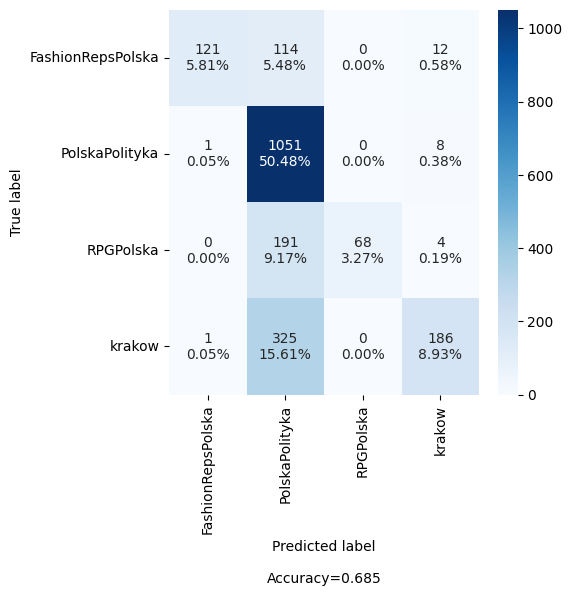

In [ ]:

plt.rcParams["figure.figsize"] = (5,5)
make_confusion_matrix(conf_mat,categories=le.classes_);


## 2.7 Kiedy klasyfiaktor pomylił się

Z ```df_pl``` wybierz teksty, dla których było sporo błednych klasyfikacji. W naszym przykładzie może to b yć ```krakow```.


In [ ]:
df_pl.head()

In [ ]:
df_kr = df_pl[df_pl.subreddit=='krakow'].copy()
df_kr.head()

,text,subreddit,link_flair_text
1803,znalezione na kazimierzu &#x200b; https://prev...,krakow,Photo
1804,"gryl w krakowie hej! majówka przyszła, więc se...",krakow,Question
1810,"fajne, mniej uczęszczane spoty na deskę? nie m...",krakow,Question
1814,"szukam ludzi do ankiety - poglądy, nastroje sp...",krakow,Question
1815,sąd skazał narodowców za groźby wobec europosł...,krakow,None


In [ ]:
pipeline.predict(df_kr.text)


**TODO 11.2.7.1** Dokonaj klasyfkiacji danych w ```df_kr```. Wyniki w postaci etykiet tekstowych dodaj jako kolumnę o nazwie ```pred```.

In [ ]:
p=???
df_kr['pred']=p
df_kr.head()

,text,subreddit,link_flair_text,pred
1803,znalezione na kazimierzu &#x200b; https://prev...,krakow,Photo,krakow
1804,"gryl w krakowie hej! majówka przyszła, więc se...",krakow,Question,krakow
1810,"fajne, mniej uczęszczane spoty na deskę? nie m...",krakow,Question,krakow
1814,"szukam ludzi do ankiety - poglądy, nastroje sp...",krakow,Question,krakow
1815,sąd skazał narodowców za groźby wobec europosł...,krakow,None,PolskaPolityka


**TODO 11.2.7.2** utwórz tabelę danych zawierającą tylko te wiersze, dla których etykiety subreddit i pred są rózne. 

Przeglądnij przykłady i dla kilku z nich spróbuj uzasadnić decyzję klasyfikatora.

In [ ]:
df_kr_diff=???
df_kr_diff.head(100)

,text,subreddit,link_flair_text,pred
1815,sąd skazał narodowców za groźby wobec europosł...,krakow,None,PolskaPolityka
1826,kursy gotowanie w krakowie czy jest jakiś miej...,krakow,None,PolskaPolityka
1839,radnego zaniepokoiła dominacja kenijczyków w c...,krakow,None,PolskaPolityka
1866,poczujesz się jak górnik po trzech latach prze...,krakow,None,PolskaPolityka
1870,o co chodzi z tym świadectwem energetycznym? [...,krakow,None,PolskaPolityka
...,...,...,...,...
2457,"to, co zostało ze spalonego archiwum spiskowe ...",krakow,None,PolskaPolityka
2470,"kampus przy al mickiewicza gotowy, po kontrowe...",krakow,None,PolskaPolityka
2471,kraków po nuklearnej zagładzie polski superboh...,krakow,None,PolskaPolityka
2472,nie żyje najstarsza w polsce pracująca sprzeda...,krakow,None,PolskaPolityka


## 2.8 Strojenie parametrów (grid search)

Przeprowadzimy strojenie parametru ```alpha``` klasyfikatora używając wartości z podanego zakresu.

In [ ]:
alpha = np.linspace(0.001,1,100,endpoint=True)
print(alpha)

[0.001      0.01109091 0.02118182 0.03127273 0.04136364 0.05145455
 0.06154545 0.07163636 0.08172727 0.09181818 0.10190909 0.112
 0.12209091 0.13218182 0.14227273 0.15236364 0.16245455 0.17254545
 0.18263636 0.19272727 0.20281818 0.21290909 0.223      0.23309091
 0.24318182 0.25327273 0.26336364 0.27345455 0.28354545 0.29363636
 0.30372727 0.31381818 0.32390909 0.334      0.34409091 0.35418182
 0.36427273 0.37436364 0.38445455 0.39454545 0.40463636 0.41472727
 0.42481818 0.43490909 0.445      0.45509091 0.46518182 0.47527273
 0.48536364 0.49545455 0.50554545 0.51563636 0.52572727 0.53581818
 0.54590909 0.556      0.56609091 0.57618182 0.58627273 0.59636364
 0.60645455 0.61654545 0.62663636 0.63672727 0.64681818 0.65690909
 0.667      0.67709091 0.68718182 0.69727273 0.70736364 0.71745455
 0.72754545 0.73763636 0.74772727 0.75781818 0.76790909 0.778
 0.78809091 0.79818182 0.80827273 0.81836364 0.82845455 0.83854545
 0.84863636 0.85872727 0.86881818 0.87890909 0.889      0.89909091
 0.90

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

params = {'multinomialnb__alpha':alpha}
grid = GridSearchCV(pipeline, params, scoring="f1_macro",cv=10, verbose=1)
grid.fit(df_pl['text'], y)
grid.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'multinomialnb__alpha': 0.06154545454545455}

**TODO 11.2.8.1** Wykorzystaj wyznaczoną wartość ```alpha``` aby:
* przeprowadzić walidację krzyżową dla odpowiednio skonfigurowanego klasyfikatora
* obliczyć wartości średnie metryk
* wyświetlić wynikową macierz pomyłek

In [ ]:
from sklearn.model_selection import cross_validate
cls = MultinomialNB(alpha=???)

pipeline = make_pipeline(vectorizer, cls)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
cv_results = cross_validate...
# print(cv_results)

acc=0.8347856091277143 prec=0.8468666020502654 recall=0.8187053550818811 f1=0.8292965160845004


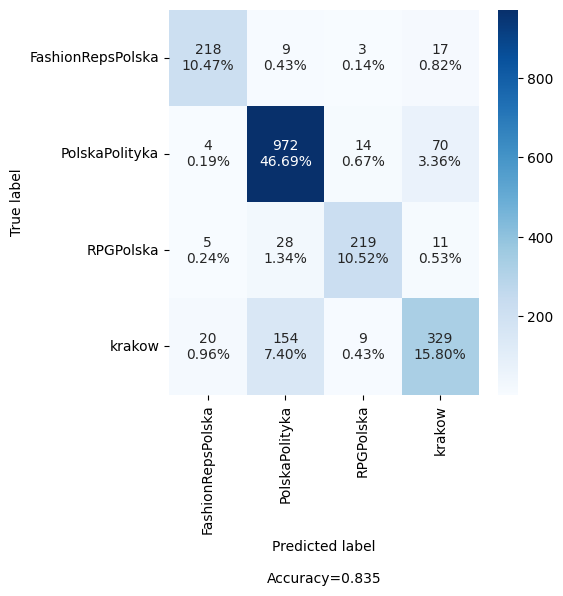

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
???
conf_mat = ???
make_confusion_matrix(conf_mat,categories=le.classes_);